In [101]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
from matplotlib import pyplot

In [102]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            pyplot.subplot2grid((3,3),(i,j))
            pyplot.imshow(X[k])
            k = k+1
    pyplot.show()


# EDA

In [103]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

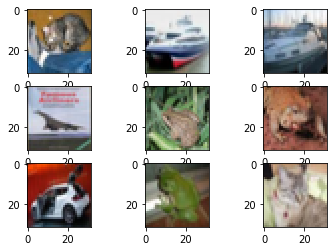

In [104]:
#visualise test data
show_imgs(x_test[:9])

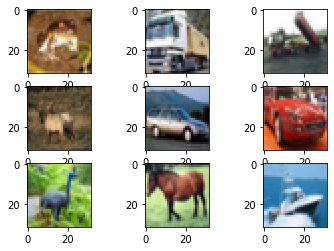

In [105]:
#visualise training data
show_imgs(x_train[:9])

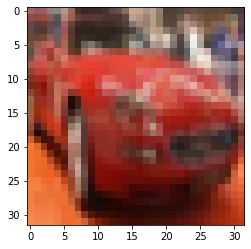

In [106]:
pyplot.imshow(x_train[5])

In [107]:
print('X train: ' , x_train.shape)
print('Y train: ' , y_train.shape)
print('X test: ', x_test.shape)
print('Y test: ', y_test.shape)

X train:  (50000, 32, 32, 3)
Y train:  (50000, 1)
X test:  (10000, 32, 32, 3)
Y test:  (10000, 1)


# Preprocessing

In [108]:
#data augmentation and normalization

from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#mean = np.mean(x_train,axis=(0,1,2,3))
#std = np.std(x_train,axis=(0,1,2,3))
#x_train = (x_train-mean)/(std+1e-7)
#x_test = (x_test-mean)/(std+1e-7)
x_train = x_train/255
x_test = x_test/255

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

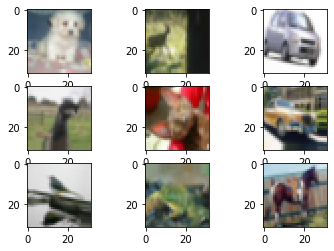

In [109]:
#visualise augmented and normalised training images

from matplotlib import pyplot as plt

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=True):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(32, 32, 3))
    plt.show()
    break

In [110]:
print('Labels:' , np.unique(y_train))

Labels: [0 1 2 3 4 5 6 7 8 9]


In [111]:
#one hot encode target variable

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [80]:
y_test[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# Model

In [24]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [25]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [37]:
model = Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['acc'])

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_5 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 multiple                  0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
batch_normalization_6 (Batch multiple                  131072    
_________________________________________________________________
dense_6 (Dense)              multiple                  4194432   
_________________________________________________________________
dropout_4 (Dropout)          multiple                 

In [39]:
#train
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), verbose=1, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
782/782 [==============================] - 4964s 6s/step - loss: 1.8206 - acc: 0.4055 - val_loss: 2.0526 - val_acc: 0.3029
Epoch 2/2
782/782 [==============================] - 4915s 6s/step - loss: 1.0016 - acc: 0.7121 - val_loss: 0.4692 - val_acc: 0.8753


In [41]:
#train
history1 = model.fit(datagen.flow(x_train, y_train, batch_size=64), verbose=1, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
782/782 [==============================] - 5047s 6s/step - loss: 0.7482 - acc: 0.8064 - val_loss: 0.3553 - val_acc: 0.9051
Epoch 2/2
782/782 [==============================] - 5764s 7s/step - loss: 0.6189 - acc: 0.8505 - val_loss: 0.3036 - val_acc: 0.9219


In [114]:
#test
model.evaluate(x_test, y_test)

313/313 [==============================] - 186s 593ms/step - loss: 0.3036 - acc: 0.9219


[0.3036176860332489, 0.9218999743461609]

In [64]:
model.save('model.h5')

# Load Saved Model and Predict

In [113]:
# reload model
model = tf.keras.models.load_model('model.h5')
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['acc'])

In [115]:
x = np.argmax(model.predict(x_test[0:10000]),1)

In [116]:
#frequency count for each predicted class
np.array(np.unique(x, return_counts=True)).T

array([[   0, 1066],
       [   1,  997],
       [   2,  973],
       [   3,  853],
       [   4, 1022],
       [   5,  965],
       [   6, 1074],
       [   7, 1036],
       [   8,  987],
       [   9, 1027]], dtype=int64)

In [117]:
predictions = x[7000:7009]

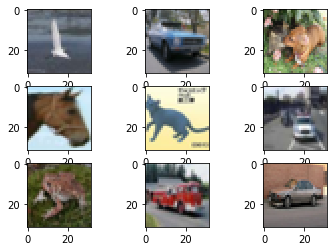

Predicted:  ['ship', 'automobile', 'frog', 'horse', 'horse', 'truck', 'frog', 'truck', 'automobile']
True Labels:  ['bird', 'automobile', 'cat', 'horse', 'cat', 'automobile', 'frog', 'truck', 'automobile']


In [129]:
#visualise test results

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

show_imgs(x_test[7000:7009])
 
#true value of labels
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#indices = np.argmax(model.predict(x_test[7000:7009]),1)
print ('Predicted: ', [labels[x] for x in predictions])

val = []
for x in y_test[7000:7009]:
    val.append(x[0])
print('True Labels: ', [labels[x] for x in val])

# Analyze Permormance

In [52]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df = hist_df.append(pd.DataFrame(history1.history))

In [53]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   loss      4 non-null      float64
 1   acc       4 non-null      float64
 2   val_loss  4 non-null      float64
 3   val_acc   4 non-null      float64
dtypes: float64(4)
memory usage: 160.0 bytes


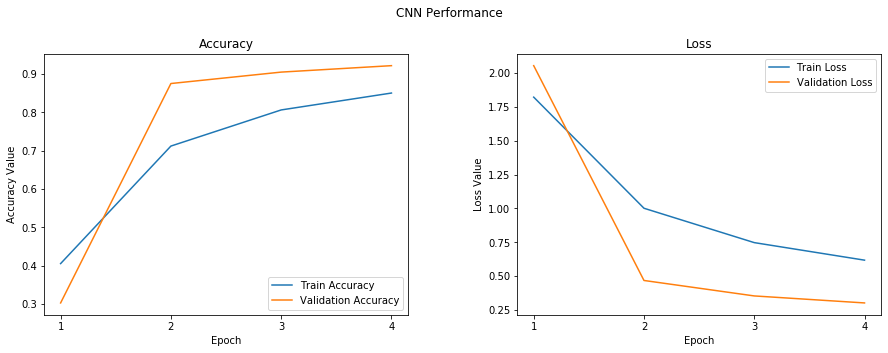

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,4+1))
ax1.plot(epochs, hist_df['acc'], label='Train Accuracy')
ax1.plot(epochs, hist_df['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, hist_df['loss'], label='Train Loss')
ax2.plot(epochs, hist_df['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")